In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 8.2 MB 42.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import time
import nltk
from nltk.stem import WordNetLemmatizer
from pymorphy2 import MorphAnalyzer
from gensim.models import word2vec, doc2vec

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (Input, concatenate, Activation, Conv1D, Embedding,
                                     Conv1DTranspose, MaxPooling1D, BatchNormalization, )

from google.colab import files

nltk.download('wordnet')   # сеть для лемматизации

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Лист Тэгов:
# <s1> - Условия договора
# <s2> - Запреты
# <s3> - Стоимость
# <s4> - Условия
# <s5> - Штрафы
# <s6> - Адреса

In [ ]:
# Путь к папке с договорами.
path = '/content/drive/MyDrive/UAI/Data_CSV/Договора432/'
contracts_432 = os.listdir('/content/drive/MyDrive/UAI/Data_CSV/Договора432/')
len(contracts_432)

432

In [ ]:
# Функция считывания файла и очистки и от ненужных знаков и дополнения нужными
def read_text(file_name):
    t = open(file_name, 'r')
    text = t.read()
    del_symbols =  ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']
    for symb in del_symbols:
        text = text.replace(symb, ' ')
    # Ищем и заменям дополнительные знаки в тексте
    text = re.sub('[.]', ' ', text)
    text = re.sub(':', ' ', text)
    text = re.sub('<', ' <', text)
    text = re.sub('>', '> ', text)

    text = ' '.join(text.split())   # Собираем последовательности слов в текст с пробелами между ними
    text = text.lower()             # Приводим все к нижнему регистру

    return text

In [ ]:
# Функция конвертации текста в начальную форму списка
def text2Words(text):
    morph = MorphAnalyzer()   # Инструмент для работы с морфемами
    words = text.split(' ')
    elements = [morph.parse(word)[0].normal_form for word in words]   # Каждое слово в элемент списка

    return elements

In [ ]:
# Загружаем файлы договоров
contracts = []
for file_name in os.listdir(path):
    txt = read_text(path + file_name)
    if file_name != '':
        contracts.append(read_text(path + file_name))
print(f'Количество файлов= {len(contracts)}')

Количество файлов= 432


In [ ]:
# Пример получившегося договора
contr = 3
print(f'Наименование: {os.listdir(path)[contr]}')
print('- - - - - - - - - - - - - - - - - - - - - - - ')
print(f'Tекст: {contracts[contr]}')

Наименование: 2 (5).txt
- - - - - - - - - - - - - - - - - - - - - - - 
Tекст: договор пожизненного содержания с иждивением с предоставлением иного жилого помещения для проживания взамен передаваемого г г гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем получатель ренты с одной стороны и гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем плательщик ренты с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 предмет договора 1 1 <s1> получатель ренты передает плательщику ренты в собственность квартиру <s6> расположенную по адресу </s6> именуемую в дальнейшем передаваемое помещение а плательщик ренты в обмен на полученное помещение предоставляет получателю ренты квартиру комнату для проживания и <s3> обязуется осуществлять пожизненное содержание с иждивением получателя ренты под содержанием с иждивением в настоящем договоре понимается обеспечение потребностей получате

In [ ]:
# Переводим все договора в списки документов
contracts_full = []
for contr in range(len(contracts)):
    contracts_full.append(text2Words(contracts[contr]))
print(f'Количество  в списке= {len(contracts_full)}')

Количество  в списке= 432


In [ ]:
# Выбираем количество записей для обучающей и проверочной выбори
contr_train = contracts_full[:-20]
contr_test = contracts_full[-20:]
print(f' Обучаюая выбора= {len(contr_train)} \n Тестовая выборка= {len(contr_test)}')

 Обучаюая выбора= 412 
 Тестовая выборка= 20


In [ ]:
# Пример текста и леммы этого текста
print(f'Пример текста: {contracts[10][:50]}')
print(f'Пример лемм: {contr_train[10][:50]}')

Пример текста: договор на хранение валютных средств на депозитных
Пример лемм: ['договор', 'на', 'хранение', 'валютный', 'средство', 'на', 'депозитный', 'счёт', 'в', 'уполномоченный', 'коммерческий', 'банк', 'г', 'г', 'уполномоченный', 'коммерческий', 'банк', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'банк', 'с', 'один', 'сторона', 'и', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'вкладчик', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в']


Создание X_train

In [ ]:
# Создаем токенайзер и превращаем список в словарь
tokenizer = Tokenizer(lower=True, filters='', char_level=False)
tokenizer.fit_on_texts(contracts_full)

vocabulary = {}
for item in tokenizer.word_index.items():
    vocabulary[item[0]] = item[1]             # смена мест
    
print(f'Длина словаря: {len(vocabulary)}')

Длина словаря: 5843


In [ ]:
# Индекс тега
print('Индекс тега <s1> : ', vocabulary['<s1>'])
print('Индекс тега <s2> : ', vocabulary['<s2>'])

Индекс тега <s1> :  12
Индекс тега <s2> :  341


In [ ]:
# Текст в последовательность индексов согласно словаря частотности
contracts_indexes = tokenizer.texts_to_sequences(contr_train)

In [ ]:
# Смотрим на текст и соответствующие ему индексы
print(f'Фрагмент обучающей выборки: {contr_train[10][:50]}')
print(f'Последовательность индексов: {contracts_indexes[10][:50]}')

Фрагмент обучающей выборки: ['договор', 'на', 'хранение', 'валютный', 'средство', 'на', 'депозитный', 'счёт', 'в', 'уполномоченный', 'коммерческий', 'банк', 'г', 'г', 'уполномоченный', 'коммерческий', 'банк', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'банк', 'с', 'один', 'сторона', 'и', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'вкладчик', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в']
Последовательность индексов: [2, 10, 162, 688, 88, 10, 1618, 59, 1, 355, 348, 108, 76, 76, 355, 348, 108, 1, 35, 38, 10, 65, 62, 1, 46, 108, 8, 69, 7, 3, 1, 35, 38, 10, 65, 62, 1, 46, 602, 8, 33, 7, 62, 1, 46, 7, 109, 9, 2, 1]


Создаем y_train

In [ ]:
# Лист индесов и их мультилейбл
def create_XY_samples(contracts_indexes, tags_indexes):
    tags = []
    indexes = []
    
    for contr in contracts_indexes:
        tag_array = np.zeros(6)
        #tag_array = [0, 0, 0, 0, 0, 0]
        for ind in contr:
            if ind in tags_indexes:
                place = np.argwhere(tags_indexes == ind)
                if len(place) != 0:
                    if place[0][0]  < 6:               # первые 6 открывающие теги
                        tag_array[place[0][0]] = 1     # устанавливаем значение 1
                    else:
                        tag_array[place[0][0]-6] = 0  # остальные закрывающие закрывающие меняем на 0
            else:
                tags.append(tag_array.copy())      # добавляем новые вектора мультилейблов
                indexes.append(ind)                # добавляем индекс слова

    return indexes, tags

In [ ]:
# Лист слов из листа индексов, со сменой местами ключей и значений
def reverse_indexes(vocabulary, X):
    reverse_keys_items = dict(map(reversed, vocabulary.items()))
    contr_train = [reverse_keys_items.get(ki) for ki in X]   # складываем в лист

    return contr_train

In [ ]:
# Создаем списки открывающих и закрывающих тэгов, затем конкатенируем их
opening_tags = ['<s' + str(t) + '>' for t in range(1, 7)]
closing_tags = ['</s' + str(t) + '>' for t in range(1, 7)]
opening_tags.extend(closing_tags)
# Получам индексы всех тэгов из словаря частотности
tags_indexes = np.array([vocabulary[t] for t in opening_tags])

print(f'Индексы всех Тэгов: {tags_indexes}')

Индексы всех Тэгов: [ 12 341  22  27 117 278  13 352  23  28 118 273]


In [ ]:
# Создаем листы x, y с полученными тэгами
X_data, y_data = create_XY_samples(contracts_indexes, tags_indexes)
# Готовим лист для эмбеддинга
decoded_contracts = reverse_indexes(vocabulary, X_data)

In [ ]:
# Посмотрим на полученные данные
print('Длина X_data: ', len(X_data))
print('Длина y_data: ', len(y_data))
print()
print('Пример текста: ', contr_train[10][:68])
print('Пример декодированного текста: ', decoded_contracts[:68])
print()
print('Часть X_data: ', X_data[:68])
print('Часть y_data: ', y_data[:68])

Длина X_data:  400878
Длина y_data:  400878

Пример текста:  ['договор', 'на', 'хранение', 'валютный', 'средство', 'на', 'депозитный', 'счёт', 'в', 'уполномоченный', 'коммерческий', 'банк', 'г', 'г', 'уполномоченный', 'коммерческий', 'банк', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'банк', 'с', 'один', 'сторона', 'и', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'вкладчик', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', '<s1>', '<s3>', 'вкладчик', 'передавать', 'а', 'банк', 'принимать', 'на', 'хранение']
Пример декодированного текста:  ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин

Разделение выборки на окна

In [ ]:
# Задаем параметры окон
X_len = 256
step = 30
embedding_size = 300
n_classes = 6
input_shape = (step, embedding_size)

In [ ]:
# Создание выбори из индексов
def set_from_indexes(word_indexes, X_len, step):
    X_batch = []                   # список для хранения фрагментов текста
    text_len = len(word_indexes)   # длина текста
    index = 0                      # начальный индекс

    while (index + X_len <= text_len):
        X_batch.append(word_indexes[index:index+X_len])
        index += step

    return X_batch

In [ ]:
# Генерируем выборки с параметрами окон
X_train = set_from_indexes(decoded_contracts, X_len, step)
y_train = set_from_indexes(y_data, X_len, step)

In [ ]:
print('Длина X_train: ', len(X_train))
print('Длина y_train: ', len(y_train))
print('Длина примера X_train: ', len(X_train[10]))
print('Длина примера y_train: ', len(y_train[10]))
print()
print('Пример X_train: ', X_train[10])
print('Пример y_train: ', y_train[10])

Длина X_train:  13355
Длина y_train:  13355
Длина примера X_train:  256
Длина примера y_train:  256

Пример X_train:  ['на', 'хранение', 'как', 'за', 'свой', 'собственный', '2', '1', '8', 'возвратить', 'поклажедатель', 'тот', 'самый', 'вещь', 'который', 'быть', 'передать', 'на', 'хранение', 'вещь', 'должный', 'быть', 'возвратить', 'хранитель', 'в', 'тот', 'состояние', 'в', 'какой', 'она', 'быть', 'принять', 'на', 'хранение', 'с', 'учёт', 'она', 'естественный', 'ухудшение', 'естественный', 'убыль', 'или', 'иной', 'изменение', 'вследствие', 'она', 'естественный', 'свойство', '2', '2', 'поклажедатель', 'обязываться', '2', '2', '1', 'при', 'получение', 'уведомление', 'от', 'хранитель', 'о', 'необходимость', 'изменение', 'условие', 'хранение', 'вещь', 'п', '2', '1', '6', 'настоящий', 'договор', 'направить', 'соответствовать', 'ответ', 'хранитель', 'в', 'течение', 'день', 'с', 'дата', 'получение', 'указанный', 'уведомление', '2', '2', '2', 'возместить', 'хранитель', 'расход', 'на', 'хранение

In [ ]:
# Текст в последовательность индексов по словарю частотности
contracts_test = tokenizer.texts_to_sequences(contr_test)

In [ ]:
# Распознаём теги
X_data_test, y_data_test = create_XY_samples(contracts_test, tags_indexes)
# Превращаем лист индексов обратно в лист слов дляеьбеддинга
decoded_contracts = reverse_indexes(vocabulary, X_data_test)

In [ ]:
# Генерируем выборки с параметрами окон
X_test = set_from_indexes(decoded_contracts, X_len, step)   # последовательность индексов с окном слов
y_test = set_from_indexes(y_data_test, X_len, step)         # последовательность индексов с окном тегов

In [ ]:
# 
print('Длина X_test: ', len(X_test))
print('Длина y_test: ', len(y_test))
print('Длина примера X_test: ', len(X_test[10]))
print('Длина примера y_test: ', len(y_test[10]))
print()
print('Пример X_train: ', X_test[10])
print('Пример y_train: ', y_test[10])

Длина X_test:  678
Длина y_test:  678
Длина примера X_test:  256
Длина примера y_test:  256

Пример X_train:  ['в', 'коллектив', 'отдел', 'осуществлять', 'планирование', 'учёт', 'составление', 'и', 'своевременный', 'представление', 'отчётность', 'о', 'деятельность', 'отдел', 'осуществлять', 'подбор', 'кандидатура', 'на', 'замещение', 'вакантный', 'должность', 'сотрудник', 'подразделение', 'и', 'представлять', 'они', 'генеральный', 'директор', 'общество', 'для', 'назначение', 'на', 'должность', 'а', 'также', 'обеспечивать', 'целесообразный', 'использование', 'сотрудник', 'обеспечивать', 'соблюдение', 'правило', 'и', 'инструкция', 'по', 'охрана', 'труд', 'санитария', 'и', 'пожарный', 'безопасность', 'подчинённый', 'он', 'сотрудник', 'применять', 'оптимальный', 'метод', 'организация', 'труд', 'а', 'также', 'использовать', 'положительный', 'зарубежный', 'опыт', 'управление', 'коллектив', 'давать', 'конкретный', 'указание', 'подчинённый', 'сотрудник', 'по', 'весь', 'вопрос', 'отнести', 'к',

Используем Word2Vec vs Doc2Vec

In [ ]:
# Создаем функцию дополнения нулями
def add_zeros(phrase, X_len=X_len):
    while len(phrase) < X_len:
        phrase.append([0] * embedding_size)
    if len(phrase) > X_len:
        phrase = phrase[:X_len]
    return phrase

In [ ]:
# Создаем выборку
def create_sets(model, senI, tagI):
    X_vector = []          # ембеддинг представление на каждый индекс
    tmp = []               # временный список
    for txt in senI:    # проход по списку текста
        tmp = []
        for word in txt:   # проход по каждому слову списка текста
            try:           # предотаращаем ошибку
                tmp.append(model[word])
            except:
                pass
    
        X_vector.append(add_zeros(tmp, X_len))
    temp = np.array(X_vector)
    return np.array(X_vector, dtype=np.float32), np.array(tagI)

In [ ]:
# Создаем Word2Vec
model_word2vec = word2vec.Word2Vec(X_train + X_test, size=embedding_size, window=3, min_count=1, workers=4, iter=20, max_vocab_size = 1e5)

In [ ]:
model_word2vec['случай']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 2.30162549e+00, -6.35190427e-01, -4.85515855e-02,  8.39289427e-01,
       -1.67066562e+00,  1.08502901e+00, -1.69780505e+00,  2.60870844e-01,
        1.21942282e+00, -4.34570700e-01, -3.53677297e+00,  1.31408095e+00,
       -1.09312212e+00, -7.34723434e-02, -7.11979151e-01,  1.03559399e+00,
       -1.35038197e+00,  1.64468214e-01,  1.36373603e+00,  7.71098882e-02,
       -9.27964151e-01,  8.64551663e-01,  2.41167831e+00,  9.25882697e-01,
        4.71429676e-01,  1.37211192e+00,  4.69264120e-01,  4.13200110e-01,
       -4.23380267e-03, -1.85911453e+00, -5.32489181e-01,  1.39298761e+00,
        2.76896977e+00,  1.79056212e-01, -3.31823140e-01, -6.14380360e-01,
        5.46955884e-01, -6.28096819e-01, -1.88202965e+00, -5.72068952e-02,
        4.14120883e-01,  1.24109530e+00,  6.71493173e-01,  1.34384263e+00,
       -2.00439960e-01, -8.14842701e-01, -3.22252482e-01, -1.21561158e+00,
        1.87828362e+00,  2.83295321e+00,  1.27390969e+00,  1.95803130e+00,
       -3.67915750e-01, -

In [ ]:
# Создаем Обучающие и Тестовые выборки Word2Vec
word2vecTrainX, word2vecTrainY = create_sets(model_word2vec, X_train, y_train)
word2vecTestX, word2vecTestY = create_sets(model_word2vec, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
# Смотрим размерности
print('word2vecTrainX', word2vecTrainX.shape)
print('word2vecTrainY', word2vecTrainY.shape)
print('word2vecTestX', word2vecTestX.shape)
print('word2vecTestY', word2vecTestY.shape)

word2vecTrainX (13355, 256, 300)
word2vecTrainY (13355, 256, 6)
word2vecTestX (678, 256, 300)
word2vecTestY (678, 256, 6)


Функция ошибки

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

РЕЗУЛЬТАТЫ

In [ ]:
def answers_set(X, Y, model, tags, length, value):
    correct_list = np.array([0] * 6) # Массив правильных ответов
    incorrect_list =  np.array([0] * 6)  # Массив неправильных ответов
    X_array = X
    Y_array = Y
    pred = model.predict(X_array)
    pred[pred < value] = 0
    pred[pred > value] = 1

    for element in range(Y_array.shape[0]):
        for word in range(Y_array.shape[1]):
            for category in range(Y_array.shape[2]):
                if pred[element][word][category] == Y_array[element][word][category]:
                    correct_list[category] += 1
                else: 
                    incorrect_list[category] += 1
      
  # Итоговая точность для каждого класса
    for i in range(6):
        print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
    total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
    print("Средняя точность {}%".format(total))

UNet 2. Без проброссов.

In [ ]:
def Unet_2(n_classes=n_classes, input_shape=(input_shape)):
    input = Input(input_shape)

    # Down 1
    d1 = Conv1D(16, 3, padding='same')(input)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)

    d1 = Conv1D(16, 3, padding='same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)

    m1 = MaxPooling1D()(d1)

    # Down 2
    d2 = Conv1D(32, 3, padding='same')(m1)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)

    d2 = Conv1D(32, 3, padding='same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)

    m2 = MaxPooling1D()(d2)

    # Down 3
    d3 = Conv1D(64, 3, padding='same')(m2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)

    d3 = Conv1D(64, 3, padding='same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)

    m3 = MaxPooling1D()(d3)

    # Down 4
    d4 = Conv1D(128, 3, padding='same')(m3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)

    d4 = Conv1D(128, 3, padding='same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)

    m4 = MaxPooling1D()(d4)

    # Down 5
    d5 = Conv1D(256, 3, padding='same')(m4)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)

    d5 = Conv1D(256, 3, padding='same')(d5)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)

    # UP 1
    u = Conv1DTranspose(128, kernel_size=2, strides=2)(d5)
    u = BatchNormalization()(u)
    u = Activation('relu')(u)

    u = Conv1D(128, 3, padding='same')(u)
    u = BatchNormalization()(u)
    u = Activation('relu')(u)

    #u = Conv1D(128, 3, padding='same')(u)
    #u = BatchNormalization()(u)
    #u = Activation('relu')(u)

    # UP 2
    u2 = Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(u)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)    

    u2 = Conv1D(64, 3, padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)

    #u2 = Conv1D(64, 3, padding='same')(u2)
    #u2 = BatchNormalization()(u2)
    #u2 = Activation('relu')(u2)

    # UP 3
    u3 = Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(u2)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    u3 = Conv1D(32, 3, padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    #u3 = Conv1D(32, 3, padding='same')(u3)
    #u3 = BatchNormalization()(u3)
    #u3 = Activation('relu')(u3)
    
    # UP 4
    u4 = Conv1DTranspose(16, kernel_size=2, strides=2, padding='same')(u3)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    u4 = Conv1D(16, 3, padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    #u4 = Conv1D(16, 3, padding='same')(u4)
    #u4 = BatchNormalization()(u4)
    #u4 = Activation('relu')(u4)

    output = Conv1D(n_classes, 3, activation='sigmoid', padding='same')(u4)

    model = Model(input, output)

    # Компилируем модель 
    model.compile(optimizer=Adam(learning_rate=0.0025 ), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 300)]        0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 256, 16)           14416     
_________________________________________________________________
batch_normalization_154 (Bat (None, 256, 16)           64        
_________________________________________________________________
activation_154 (Activation)  (None, 256, 16)           0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 256, 16)           784       
_________________________________________________________________
batch_normalization_155 (Bat (None, 256, 16)           64        
_________________________________________________________________
activation_155 (Activation)  (None, 256, 16)           0   

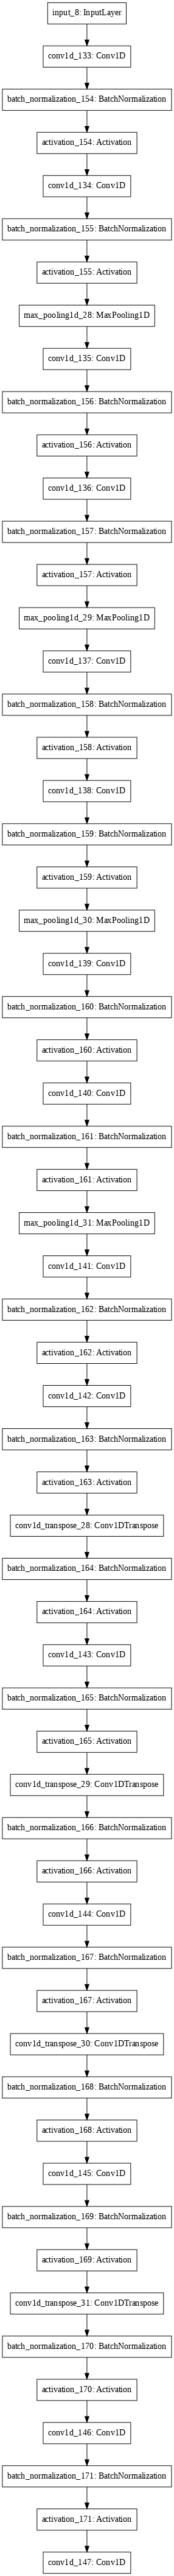

In [ ]:
model_UNet_2 = Unet_2(input_shape=(X_len, embedding_size))
model_UNet_2.summary()
plot_model(model_UNet_2, dpi=70)

In [ ]:
history_UNet_2 = model_UNet_2.fit(word2vecTrainX, word2vecTrainY, validation_data = (word2vecTestX, word2vecTestY), epochs=100, batch_size=64)

Epoch 1/100
209/209 [==============================] - 14s 40ms/step - loss: 0.9700 - dice_coef: 0.3380 - val_loss: 1.7814 - val_dice_coef: 0.3247
Epoch 2/100
209/209 [==============================] - 7s 32ms/step - loss: 0.9892 - dice_coef: 0.3843 - val_loss: 6.2688 - val_dice_coef: 0.3195
Epoch 3/100
209/209 [==============================] - 7s 32ms/step - loss: 1.1117 - dice_coef: 0.3683 - val_loss: 1.3918 - val_dice_coef: 0.2489
Epoch 4/100
209/209 [==============================] - 7s 32ms/step - loss: 1.2987 - dice_coef: 0.3311 - val_loss: 1.9039 - val_dice_coef: 0.2493
Epoch 5/100
209/209 [==============================] - 6s 31ms/step - loss: 1.5496 - dice_coef: 0.3256 - val_loss: 1.1932 - val_dice_coef: 0.2317
Epoch 6/100
209/209 [==============================] - 6s 31ms/step - loss: 1.7757 - dice_coef: 0.3274 - val_loss: 1.4399 - val_dice_coef: 0.2356
Epoch 7/100
209/209 [==============================] - 6s 31ms/step - loss: 2.0977 - dice_coef: 0.3301 - val_loss: 3.8379 -

In [ ]:
# Дообучаем UNet_2
model_UNet_2.compile(optimizer=Adam(learning_rate=0.0001 ), loss='categorical_crossentropy', metrics=[dice_coef])
history_UNet_2 = model_UNet_2.fit(word2vecTrainX, word2vecTrainY, validation_data = (word2vecTestX, word2vecTestY), epochs=100, batch_size=64)

Epoch 1/100
209/209 [==============================] - 12s 35ms/step - loss: 122.5781 - dice_coef: 0.3390 - val_loss: 35.0451 - val_dice_coef: 0.1848
Epoch 2/100
209/209 [==============================] - 7s 32ms/step - loss: 121.1505 - dice_coef: 0.3396 - val_loss: 32.5772 - val_dice_coef: 0.1793
Epoch 3/100
209/209 [==============================] - 7s 32ms/step - loss: 121.8313 - dice_coef: 0.3394 - val_loss: 34.4249 - val_dice_coef: 0.1825
Epoch 4/100
209/209 [==============================] - 7s 32ms/step - loss: 122.8248 - dice_coef: 0.3396 - val_loss: 33.9751 - val_dice_coef: 0.1803
Epoch 5/100
209/209 [==============================] - 6s 30ms/step - loss: 122.4319 - dice_coef: 0.3399 - val_loss: 34.0410 - val_dice_coef: 0.1794
Epoch 6/100
209/209 [==============================] - 6s 30ms/step - loss: 123.1180 - dice_coef: 0.3400 - val_loss: 32.3291 - val_dice_coef: 0.1750
Epoch 7/100
209/209 [==============================] - 6s 30ms/step - loss: 123.3027 - dice_coef: 0.3394 

РЕЗУЛЬТАТЫ UNet_2.


In [ ]:
answers_set(word2vecTestX, word2vecTestY, model_UNet_2, tags, X_len, 0.5)

Сеть распознала категорию  'S1' с точностью в 65.03%
Сеть распознала категорию  'S2' с точностью в 87.83%
Сеть распознала категорию  'S3' с точностью в 83.14%
Сеть распознала категорию  'S4' с точностью в 81.26%
Сеть распознала категорию  'S5' с точностью в 83.84%
Сеть распознала категорию  'S6' с точностью в 89.2%
Средняя точность 81.72%


PSPNet

In [ ]:
def PSPNet(n_classes=n_classes, input_shape=(input_shape)):
    input = Input((input_shape))

    # Entrance
    entr = Conv1D(32, 3, padding='same', activation='relu', name='entr_conv1')(input)
    entr = Conv1D(32, 3,padding='same', activation='relu', name='entr_conv2')(entr)

    # Piramid
    piramid_1 = MaxPooling1D(2)(entr)
    piramid_2 = MaxPooling1D(4)(entr)
    piramid_3 = MaxPooling1D(8)(entr)
    piramid_4 = MaxPooling1D(16)(entr)

    # Conv Layers
    conv_1 = Conv1D(64, 3, padding='same', activation='relu', name='conv_conv1')(piramid_1)
    conv_2 = Conv1D(64, 3, padding='same', activation='relu', name='conv_conv2')(piramid_2)
    conv_3 = Conv1D(64, 3, padding='same', activation='relu', name='conv_conv3')(piramid_3)
    conv_4 = Conv1D(64, 3, padding='same', activation='relu', name='conv_conv4')(piramid_4)

    # Increase size 

    incr_1 = Conv1DTranspose(64, 3, strides=2, padding='same', activation='relu')(conv_1)
    incr_2 = Conv1DTranspose(64, 3, strides=4, padding='same', activation='relu')(conv_2)
    incr_3 = Conv1DTranspose(64, 3, strides=8, padding='same', activation='relu')(conv_3)
    incr_4 = Conv1DTranspose(64, 3, strides=16, padding='same', activation='relu')(conv_4)

    # Concatenate layers
    out = concatenate([incr_1, incr_2, incr_3, incr_4])

    # Out
    out_psp = Conv1D(n_classes, 3, padding='same', activation='sigmoid')(out)

    model = Model(input, out_psp)

    model.compile(optimizer=Adam(learning_rate=0.0025 ), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
entr_conv1 (Conv1D)             (None, 256, 32)      28832       input_12[0][0]                   
__________________________________________________________________________________________________
entr_conv2 (Conv1D)             (None, 256, 32)      3104        entr_conv1[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_44 (MaxPooling1D) (None, 128, 32)      0           entr_conv2[0][0]                 
____________________________________________________________________________________________

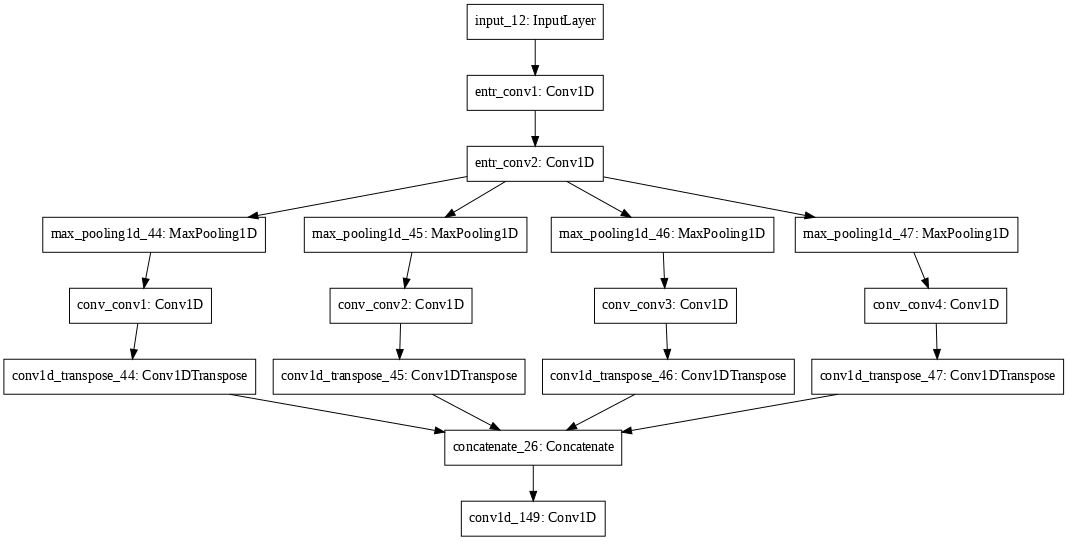

In [ ]:
model_PSPNet = PSPNet(input_shape=(X_len, embedding_size))
model_PSPNet.summary()
plot_model(model_PSPNet, dpi=70)

In [ ]:
history_PSPNet = model_PSPNet.fit(word2vecTrainX, word2vecTrainY, validation_data = (word2vecTestX, word2vecTestY), epochs=100, batch_size=64)

Epoch 1/100
209/209 [==============================] - 7s 26ms/step - loss: 769549.0000 - dice_coef: 0.0145 - val_loss: 4075944.5000 - val_dice_coef: 1.3870e-04
Epoch 2/100
209/209 [==============================] - 4s 21ms/step - loss: 59670200.0000 - dice_coef: 1.1851e-04 - val_loss: 109545752.0000 - val_dice_coef: 1.0080e-04
Epoch 3/100
209/209 [==============================] - 4s 21ms/step - loss: 654302528.0000 - dice_coef: 9.4978e-05 - val_loss: 1075521664.0000 - val_dice_coef: 1.0080e-04
Epoch 4/100
209/209 [==============================] - 4s 21ms/step - loss: 2684438016.0000 - dice_coef: 9.4451e-05 - val_loss: 3010664960.0000 - val_dice_coef: 1.0080e-04
Epoch 5/100
209/209 [==============================] - 4s 21ms/step - loss: 6981989888.0000 - dice_coef: 1.0205e-04 - val_loss: 8254108672.0000 - val_dice_coef: 1.1975e-04
Epoch 6/100
209/209 [==============================] - 4s 21ms/step - loss: 14411064320.0000 - dice_coef: 1.1260e-04 - val_loss: 20255180800.0000 - val_dic

In [ ]:
# Дообучаем
model_PSPNet.compile(optimizer=Adam(learning_rate=0.0001 ), loss='categorical_crossentropy', metrics=[dice_coef])

In [ ]:
history_PSPNet = model_PSPNet.fit(word2vecTrainX, word2vecTrainY, validation_data = (word2vecTestX, word2vecTestY), epochs=100, batch_size=64)

Epoch 1/100
209/209 [==============================] - 6s 23ms/step - loss: 23265527463936.0000 - dice_coef: 1.6381e-04 - val_loss: 13913686016000.0000 - val_dice_coef: 1.7655e-04
Epoch 2/100
209/209 [==============================] - 4s 20ms/step - loss: 19409605230592.0000 - dice_coef: 1.6413e-04 - val_loss: 13983864061952.0000 - val_dice_coef: 1.7655e-04
Epoch 3/100
209/209 [==============================] - 4s 20ms/step - loss: 19182202650624.0000 - dice_coef: 1.6213e-04 - val_loss: 13672003928064.0000 - val_dice_coef: 1.7655e-04
Epoch 4/100
209/209 [==============================] - 4s 20ms/step - loss: 18903199645696.0000 - dice_coef: 1.6333e-04 - val_loss: 13194256973824.0000 - val_dice_coef: 1.7655e-04
Epoch 5/100
209/209 [==============================] - 4s 20ms/step - loss: 18731157684224.0000 - dice_coef: 1.6234e-04 - val_loss: 13217546895360.0000 - val_dice_coef: 1.7655e-04
Epoch 6/100
209/209 [==============================] - 4s 21ms/step - loss: 18696202354688.0000 - di

In [ ]:
# Точность PSPNet
answers_set(word2vecTestX, word2vecTestY, model_PSPNet, tags, X_len, 0.5)

Сеть распознала категорию  'S1' с точностью в 69.0%
Сеть распознала категорию  'S2' с точностью в 98.2%
Сеть распознала категорию  'S3' с точностью в 85.24%
Сеть распознала категорию  'S4' с точностью в 87.61%
Сеть распознала категорию  'S5' с точностью в 93.29%
Сеть распознала категорию  'S6' с точностью в 99.9%
Средняя точность 88.87%


Дообучение в данном случае не дало результатов

Данная модель PSPNet показала результат лучше UNet.